# **CO-FOREST - PRUEBAS** 

##### **Autora: Patricia Hernando Fernández**

---------------------------
### **IMPORTS**

In [10]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
import numpy as np
import numbers
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import csv
from itertools import cycle
import time
import warnings
warnings.filterwarnings("ignore")

### **UTILS**

In [2]:
def append_to_csv(file, array):
    f = open( file, 'a')
    np.savetxt(f, array, fmt='%1.3f', newline=",")
    f.write("\n")
    f.close()


def read_irregular_csv(file):

    data = []

    with open(file) as csv_file:
        
        for row in csv.reader(csv_file):
            data.append([float(x) for x in row if x != ""])
        csv_file.close()

    return data

def create_graph_matrix(file):

    m = []
    l = read_irregular_csv(file)
    max_iters = max([[len(x)] for x in l])[0]

    for list in l:
        list = np.array(list)
        new = np.ones(shape = (max_iters)) * list[-1]
        i = np.arange(0, list.shape[0])
        new[i] = list[i]
        m.append(new)

    return np.array(m)

### **CLASS**

In [3]:
class Co_Forest:


    def __init__(self, L, y, U, n, theta, classes, random_state=None, max_features='log2',  X_test=None, y_test=None):
        """"
        Constructor. Creates and trains the Co-Forest.
        
        Parameters
        ----------
        L: np.array
            labeled data used for training
        y: np.array
            tags of the labeled data used for training
        U: np.array
            unlabeled data used for training
        n: int
            number of trees in the ensemble
        theta: float
            tolerance
        classes: np.array
            names of the classes that can be predicted
        random_state: .....
        max_features: string
            log2, sqrt, None
        """

        self.random_state = self.check_random_state(random_state)
        self.n = n
        self.theta = theta
        self.classes = classes

        self.U = U
        self.L = L
        self.y = y
        self.mask_L = np.zeros(shape=((self.L.shape[0]), self.n), dtype=int, order='C')

        self.X_test = X_test
        self.y_test = y_test

        self.ensemble = self.create_trees(max_features)
        
    def create_trees(self, max_features) -> dict:
        """Generates a dict -> {key: int, value: Tree}

        Parameters
        ----------
        max_features: number of features to consider 
                      when looking for the best split
                      'sqrt', 'log2', None

        Returns
        -------
        dict
            dict containing the trees of co-forest
        """

        ensemble = {}

        for i in range(self.n):

            rand_rows = self.random_state.choice(a = np.arange(start=0, stop=self.L.shape[0]), replace = True, size=(int(0.7*self.L.shape[0])) )
            self.mask_L[rand_rows, i] = 1
            h = DecisionTreeClassifier(max_features=max_features, random_state=self.random_state)
            ensemble[i] = h.fit(self.L[rand_rows, :], self.y[rand_rows])

        return ensemble

    def fit(self):
        """Fits the ensemble using both labeled and
        pseudo-labeled data.
        """

        if self.X_test is not None:
            scores = [self.score(self.X_test, self.y_test)]

        e = [0 for i in range(self.n)]
        W = [0 for i in range(self.n)]
        previous_e = [0.5 for i in range(self.n)]
        previous_W = [min(0.1*len(self.L), 100) for i in range(self.n)]

        new_data = True
        t = 0

        while new_data:

            t += 1
            tree_changes = np.array([False for i in range(self.n)])
            tree_pseudo_updates = [() for i in range(self.n)]

            for i, hi in self.ensemble.items():

                e[i] = self.concomitant_oob_error(hi)
                W[i] = previous_W[i]
                pseudo_labeled_data = []
                pseudo_labeled_tags = []

                if e[i] < previous_e[i]:

                    if e[i] == 0:
                        Wmax = self.theta * self.U.shape[0]
                    else:
                        Wmax = min(self.theta * self.U.shape[0], ((previous_e[i]*previous_W[i])/e[i]) )

                    U_subsampled = self.subsample(hi, Wmax) 
                    W[i] = 0

                    for u in U_subsampled:
                        concomitant_confidence, selected_class = self.concomitant_confidence(hi, self.U[u, :])

                        if concomitant_confidence > self.theta:
                            tree_changes[i] = True
                            pseudo_labeled_data.append(self.U[u, :])
                            pseudo_labeled_tags.append(selected_class)
                            W[i] += concomitant_confidence

                tree_pseudo_updates[i] = ( (np.array(pseudo_labeled_data), np.array(pseudo_labeled_tags) ) )

            for i in np.fromiter(self.ensemble.keys(), dtype=int)[tree_changes]:
                
                if e[i] * W[i] < previous_e[i] * previous_W[i]:
                    self.retrain_tree(i, tree_pseudo_updates[i][0], tree_pseudo_updates[i][1])

            previous_e = deepcopy(e)
            previous_W = deepcopy(W)

            if tree_changes.sum() == 0:
                new_data = False

            if self.X_test is not None:
                scores.append(self.score(self.X_test, self.y_test))

        if self.X_test is not None:
            append_to_csv("file.csv", scores)
        
        
    def retrain_tree(self, i, pseudo_labeled_data, pseudo_labeled_tags):

        pseudo_labeled_data = (lambda x: np.expand_dims(x, axis=0) if x.ndim == 1 else x)(pseudo_labeled_data)
        X_train = np.concatenate( (self.L[self.mask_L[:, i] == 1], pseudo_labeled_data) )
        y_train = np.concatenate( (self.y[self.mask_L[:, i] == 1], pseudo_labeled_tags) )
        self.ensemble[i] = self.ensemble[i].fit(X_train, y_train)
        

    def subsample(self, hi: DecisionTreeClassifier, Wmax: float) -> np.array:
        """Samples from U uniformly at random until 
        the sum of the sample weights reaches Wmax.
        Bootstraping is applied.

        Parameters
        ----------
        hi : DecisionTreeClassifier
        Wmax: float

        Returns
        -------
        np.array
            Array containing the index of the chosen
            samples from U
        """

        W = 0
        U_subsampled = []

        while (W < Wmax):

            rand_row = self.random_state.choice(a = np.arange(start=0, stop=self.U.shape[0]))
            W += self.concomitant_confidence(hi, self.U[rand_row, :])[0]
            U_subsampled.append(rand_row)

        return np.array(U_subsampled)

        
    def concomitant_oob_error(self, hi: DecisionTreeClassifier) -> float:
        """Calculates the Out of Bag Error of the concomitant 
        ensemble of hi for the whole labeled data.

        Parameters
        ----------
        hi : DecisionTreeClassifier

        Returns
        -------
        float
            OOBE if trees voted, nan if not
        """

        errors = []

        for sample, tag in zip(self.L, self.y):
            
            n_votes = n_hits = 0 

            for i, tree in self.ensemble.items():
                if tree != hi and sample not in self.L[self.mask_L[:, i] == 1]:

                    if tree.predict([sample])[0] == tag:
                        n_hits += 1
                    n_votes +=1

            if (n_votes > 0):
                errors.append(1 - (n_hits/n_votes))

        return np.mean(a=errors)

    def concomitant_confidence(self, hi: DecisionTreeClassifier, sample: np.array) -> tuple:
        """Calculates the number of coincidences during
        prediction of the hi concomitant ensemble for a
        data sample.

        Parameters
        ----------
        hi : DecisionTreeClassifier
        sample: sample's features array

        Returns
        -------
        tuple (float, int)
            float: confidence for the sample
            int: most agreed class
        """

        count = { **dict.fromkeys([i for i in self.classes], 0)} 
        for i in (tree.predict([sample])[0] for tree in self.ensemble.values() if tree != hi):
            count[i]+= 1

        max_agreement = max(count.values())
        most_agreed_class = list(count.values()).index(max_agreement)
        return max_agreement/(len(self.ensemble) -1), most_agreed_class


    def single_predict(self, sample: np.array): 
        """Returns the class predicted by coforest
        for a given sample. Majority voting is used.

        Parameters
        ----------
        sample: np_array
            sample to predict

        Returns
        -------
        np.array:
            label predicted by coforest.
        """

        count = { **dict.fromkeys([i for i in self.classes], 0)} 
        for i in (tree.predict([sample])[0] for tree in self.ensemble.values()):
            count[i]+= 1

        max_agreement = max(count.values())
        return self.classes[list(count.values()).index(max_agreement)]


    def predict(self, samples: np.array) -> np.array:
        """Returns the labels predicted by the coforest
        for a given data.

        Parameters
        ----------
        samples: np_array
            samples to predict

        Returns
        -------
        np.array:
            labels predicted by the coforest.
        """
        
        samples = (lambda x: np.expand_dims(x, axis=0) if x.ndim == 1 else x)(samples)
        return np.array([self.single_predict(sample) for sample in samples])


    def score(self, X_test: np.array, y_test: np.array) -> float:
        """Calculates the number of hits by coforest
        given a training set.

        Parameters
        ----------
        X_test: np_array
            Samples used during testing
        y_test: np_array
            Samples' tags

        Returns
        -------
        float:
            percentage of hits.
        """
        y_predictions = self.predict(X_test)
        return np.count_nonzero(y_predictions==y_test)/len(y_test)

    def check_random_state(self, seed):
        """
        Source: SkLearn
        Turn seed into a np.random.RandomState instance.
        Parameters
        ----------
        seed : None, int or instance of RandomState
            If seed is None, return the RandomState singleton used by np.random.
            If seed is an int, return a new RandomState instance seeded with seed.
            If seed is already a RandomState instance, return it.
            Otherwise raise ValueError.
        Returns
        -------
        :class:`numpy:numpy.random.RandomState`
            The random state object based on `seed` parameter.
        """

        if seed is None or seed is np.random:
            return np.random.mtrand._rand
        if isinstance(seed, numbers.Integral):
            return np.random.RandomState(seed)
        if isinstance(seed, np.random.RandomState):
            return seed
        raise ValueError("%r cannot be used to seed a numpy.random.RandomState instance" % seed)

# **GRAPHS**

### Variación Score - Número Iteraciones

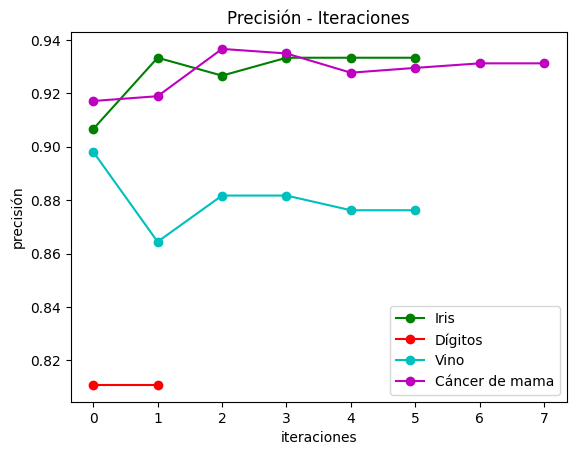

In [9]:
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

for dataset_info in available:

    dataset = dataset_info[0]
    available_classes = np.unique(dataset.target)

    X = np.array(dataset.data)
    y = np.array(dataset.target)

    rd = np.random.RandomState(5)
    kf = KFold(n_splits=10, shuffle=True, random_state=rd)
    kf.get_n_splits(X)

    open('file.csv', 'w').close()

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd)
        
        co_forest = Co_Forest(L_train, Ly_train, U_train, 6, 0.75, available_classes, rd,'log2', X_test, y_test)
        co_forest.fit()

    mean = np.mean(create_graph_matrix("file.csv"), axis=0)
    ax.plot(np.arange(len(mean)), mean, '-o', color = next(cycol), label = dataset_info[1])

plt.title("Precisión - Iteraciones")
ax.set_ylabel('precisión')
ax.set_xlabel('iteraciones')
plt.legend(loc="lower right")
plt.show()

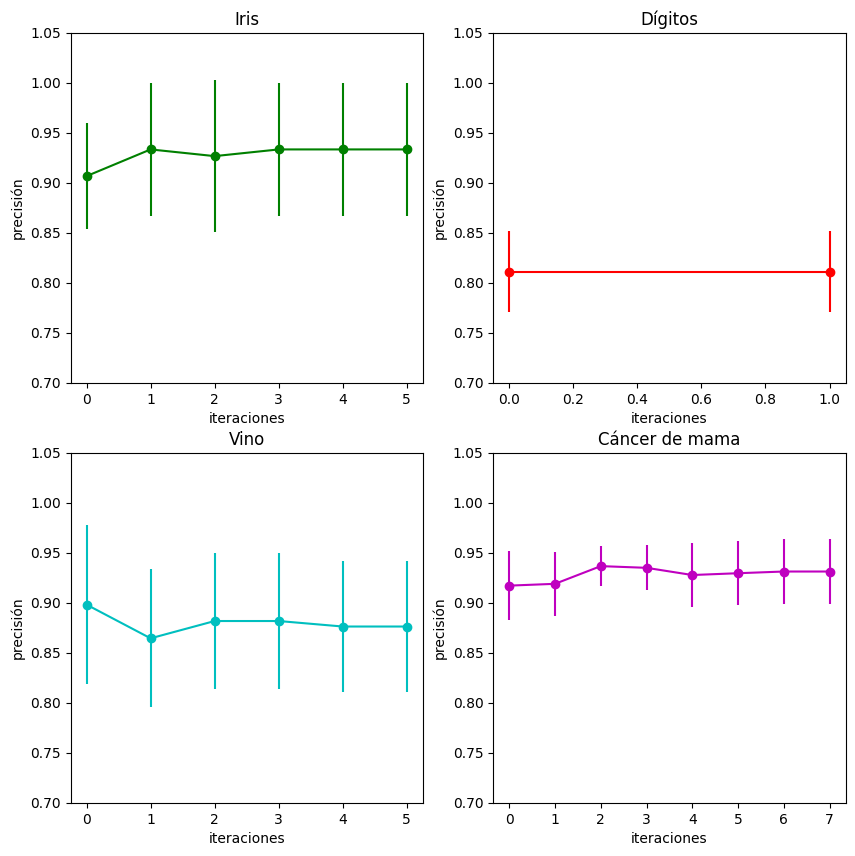

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
cycol = cycle('bgrcmk')
next(cycol)
available = [(load_iris(), 'Iris', (0,0)), (load_digits(), 'Dígitos', (0,1)), (load_wine(), 'Vino', (1,0)), (load_breast_cancer(), 'Cáncer de mama', (1,1))]

for dataset_info in available:

    dataset = dataset_info[0]
    available_classes = np.unique(dataset.target)

    X = np.array(dataset.data)
    y = np.array(dataset.target)

    rd = np.random.RandomState(5)
    kf = KFold(n_splits=10, shuffle=True, random_state=rd)
    kf.get_n_splits(X)

    open('file.csv', 'w').close()

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd)
        
        co_forest = Co_Forest(L_train, Ly_train, U_train, 6, 0.75, available_classes, rd,'log2', X_test, y_test)
        co_forest.fit()

    mean = np.mean(create_graph_matrix("file.csv"), axis=0)
    std = np.std(create_graph_matrix("file.csv"), axis=0)

    coordinates = dataset_info[2]
    ax_i = ax[coordinates[0], coordinates[1]]
    ax_i.set_ylim([0.7, 1.05])
    ax_i.errorbar(np.arange(len(mean)), mean, std, fmt='-o', color = next(cycol), label = dataset_info[1])
    ax_i.set_ylabel('precisión')
    ax_i.set_xlabel('iteraciones')
    ax_i.set_title(dataset_info[1])
    
plt.show()

### Número elementos - tiempo entrenamiento


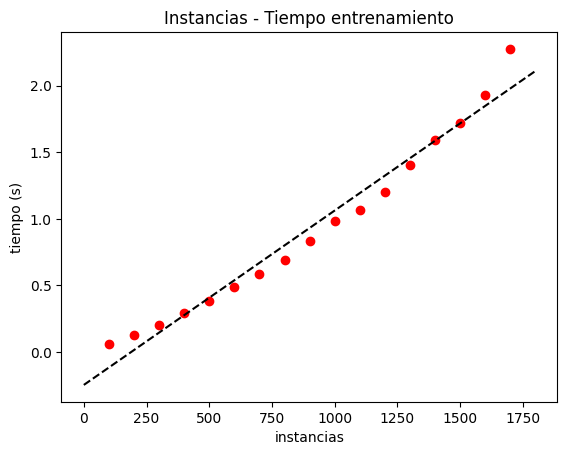

In [25]:
cycol = cycle('bgrcmk')
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
next(cycol) 

dataset_info = (load_digits(), 'Dígitos')
dataset = dataset_info[0]

instancias = []
tiempos = []
rd = np.random.RandomState(5)

for i in range(100, dataset.data.shape[0], 100):

    indexes = rd.choice(a = np.arange(start=0, stop=X.shape[0]), replace = True, size=i)
    X = np.array(dataset.data)[indexes]
    y = np.array(dataset.target)[indexes]
    L_train, U_train, Ly_train, Uy_train = train_test_split(X, y, test_size=0.8, random_state=rd)

    inicio = time.time()
    co_forest = Co_Forest(L_train, Ly_train, U_train, 20, 0.75, np.unique(dataset.target), rd,'log2')
    co_forest.fit()
    fin = time.time()

    instancias.append(X.shape[0])
    tiempos.append((fin-inicio))

ax.scatter(instancias, tiempos, color=next(cycol) )

model = LinearRegression()
model.fit(np.array([[i] for i in instancias]), tiempos)
x_new = np.linspace(0, dataset.data.shape[0], 100)
y_new = model.predict(x_new[:, np.newaxis])

plt.title("Instancias - Tiempo entrenamiento")
ax.plot(x_new, y_new, '--k')
ax.set_xlabel('instancias')
ax.set_ylabel('tiempo (s)')
plt.show()

### Score - % Instancias entrenamiento

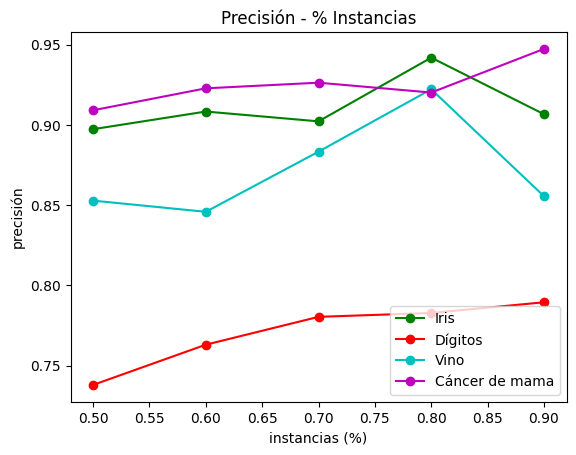

In [12]:
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
rd = np.random.RandomState(5)
available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

for dataset_info in available:

    matriz_scores = []
    dataset = dataset_info[0]
    
    for j in range(10): #Número de experimentos
        
        scores_experimento = []

        for i in np.arange(0.5, 1, 0.1):

            X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, train_size=i, random_state=rd)
            L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd)
            co_forest = Co_Forest(L_train, Ly_train, U_train, 6, 0.75, np.unique(dataset.target), rd,'log2')
            co_forest.fit()
            scores_experimento.append(co_forest.score(X_test, y_test))

        matriz_scores.append(scores_experimento)

    ax.plot(np.arange(0.5, 1, 0.1), np.mean(np.array(matriz_scores), axis=0), '-o', color=next(cycol),  label=dataset_info[1])

plt.title("Precisión - % Instancias")
ax.set_ylabel('precisión')
ax.set_xlabel('instancias (%)')
plt.legend(loc="lower right")
plt.show()

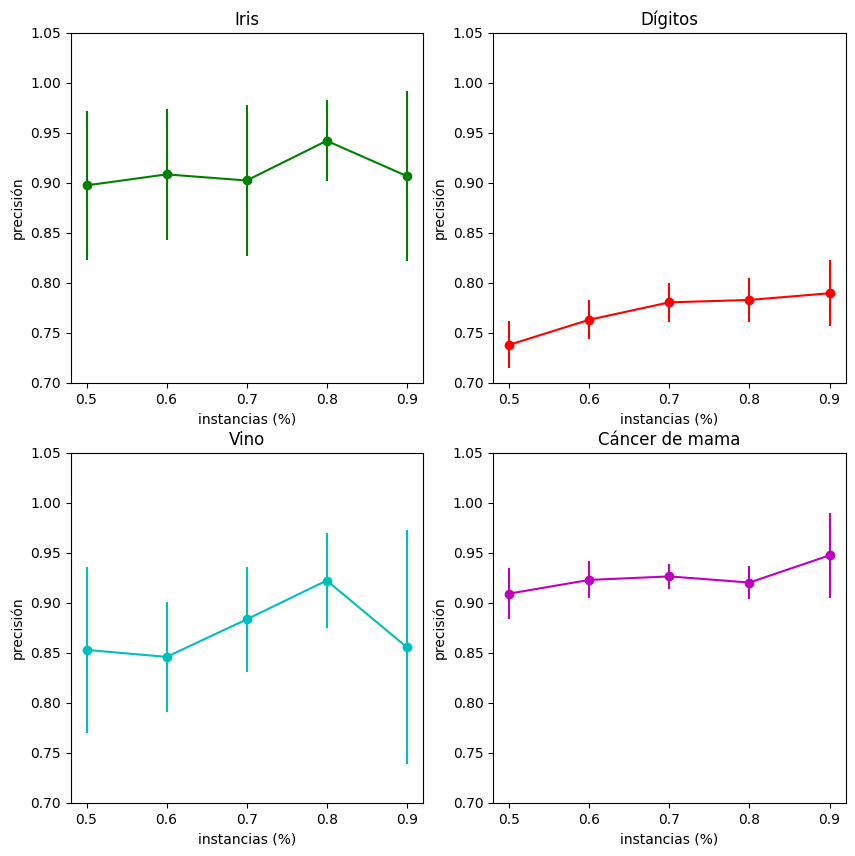

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
cycol = cycle('bgrcmk')
next(cycol)

available = [(load_iris(), 'Iris', (0,0)), (load_digits(), 'Dígitos', (0,1)), (load_wine(), 'Vino', (1,0)), (load_breast_cancer(), 'Cáncer de mama', (1,1))]
rd = np.random.RandomState(5)

for dataset_info in available:

    matriz_scores = []
    dataset = dataset_info[0]
    
    for j in range(10): #Número de experimentos
        
        scores_experimento = []

        for i in np.arange(0.5, 1, 0.1):

            X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, train_size=i, random_state=rd)
            L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd)
            co_forest = Co_Forest(L_train, Ly_train, U_train, 6, 0.75, np.unique(dataset.target), rd,'log2')
            co_forest.fit()
            scores_experimento.append(co_forest.score(X_test, y_test))

        matriz_scores.append(scores_experimento)

    coordinates = dataset_info[2]
    ax_i = ax[coordinates[0], coordinates[1]]
    ax_i.set_ylim([0.7, 1.05])
    ax_i.errorbar(np.arange(0.5, 1, 0.1), np.mean(np.array(matriz_scores), axis=0), np.std(np.array(matriz_scores), axis=0), fmt='-o', color = next(cycol), label=dataset_info[1])
    ax_i.set_ylabel('precisión')
    ax_i.set_xlabel('instancias (%)')
    ax_i.set_title(dataset_info[1])

plt.show()

### Score - Número instancias (ignorada)

In [15]:
# cycol = cycle('bgrcmk')
# fig, ax = plt.subplots()
# rd = np.random.RandomState(5)
# available = [(load_iris(), 'Iris'), (load_digits(), 'Digits'), (load_wine(), 'Wine'), (load_breast_cancer(), 'Breast Cancer')]

# for dataset_info in available:

#     instancias = []
#     scores_instancias = []
#     dataset = dataset_info[0]
#     available_classes = np.unique(dataset.target)

#     X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=rd)

#     for i in range(100, X_train.shape[0], 100):

#         L_train, U_train, Ly_train, Uy_train = train_test_split(X_train[np.arange(stop=i)], y_train[np.arange(stop=i)], test_size=0.8, random_state=rd)
#         co_forest = Co_Forest(L_train, Ly_train, U_train, 20, 0.75, available_classes, rd,'log2')
#         co_forest.fit()
#         instancias.append(i)
#         scores_instancias.append(co_forest.score(X_test, y_test))

#     ax.plot(instancias, scores_instancias, 'o-', c = next(cycol), label = dataset_info[1])


# plt.title("Score - Número de instancias")
# ax.set_ylabel('Score')
# ax.set_xlabel('Instancias')
# plt.legend(loc="lower right")
# plt.show()